# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [85]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [86]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv" ,delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_table("AZDIAS_Feature_Summary.csv",sep=';')

In [87]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [88]:
feat_info.head(10)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [89]:
azdias['ALTERSKATEGORIE_GROB'].value_counts()

3    358533
4    228510
2    158410
1    142887
9      2881
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [90]:
azdias['ALTERSKATEGORIE_GROB'].dtype

dtype('int64')

In [91]:
azdias['AGER_TYP'].value_counts()

-1    677503
 2     98472
 1     79802
 3     27104
 0      8340
Name: AGER_TYP, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [92]:
azdias.isnull().sum().sum()

4896838

In [93]:
# Identify missing or unknown data values and convert them to NaNs.
print('There are {} missing values.'.format(azdias.isnull().sum().sum()))


There are 4896838 missing values.


In [94]:
missing_or_unknown = feat_info.iloc[0]['missing_or_unknown']
print(missing_or_unknown)
print(type(missing_or_unknown))

[-1,0]
<class 'str'>


### Comments: <br>
    In the cell above , one can notice that we have string objects in the missing_or_unknown column of feat_info dataframe.

In [95]:
# parsing the 'missing_or_unknown' column of the feat_info dataframe

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.extract(r"\[(.*)\]", expand=False).str.split(",")


In [96]:
feat_info['missing_or_unknown'].head(13)

0        [-1, 0]
1     [-1, 0, 9]
2        [-1, 0]
3            [0]
4           [-1]
5           [-1]
6           [-1]
7           [-1]
8           [-1]
9           [-1]
10          [-1]
11           [0]
12            []
Name: missing_or_unknown, dtype: object

In [97]:
feat_info['missing_or_unknown'].iloc[13]

['']

In [98]:
def to_int_list(l):
    output_list = []
    for el in l:
        try:
            output_list.append(int(el))
        except:
            output_list.append(el)
    return output_list

In [99]:

# replacing missing and null values with Nan values
for indx in range(len(feat_info)): #
    
    column_name = feat_info.iloc[indx]['attribute']
    missing_or_unknown = to_int_list(feat_info.iloc[indx]['missing_or_unknown'])
    for el in missing_or_unknown:
        azdias[column_name] = azdias[column_name].replace(el,np.nan)


In [100]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [101]:
print('There are {} missing values.'.format(azdias.isnull().sum().sum()))

There are 8373929 missing values.


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [102]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_values = azdias.isnull().mean()
null_values.head(10)

AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
dtype: float64

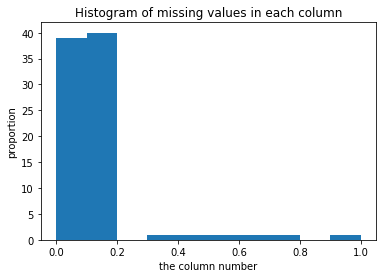

In [103]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(null_values)
plt.xlabel('the column number')
plt.ylabel('proportion')
plt.title('Histogram of missing values in each column')
plt.show()

### Comment: <br>
In the histogram above, one can observe that most columns contain missing values

In [104]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
null_values.describe()


count    85.000000
mean      0.110541
std       0.164498
min       0.000000
25%       0.000000
50%       0.104517
75%       0.130736
max       0.997576
dtype: float64

In [105]:
null_values.quantile(0.9)

0.15946931232545028

In [106]:
# We going to consider outlier columns in 90th and above percentile of null values series
percentile90th = null_values.quantile(0.9)
outlier_columns_toremove = list(null_values[null_values>percentile90th].index)
len(outlier_columns_toremove),outlier_columns_toremove

(9,
 ['AGER_TYP',
  'GEBURTSJAHR',
  'TITEL_KZ',
  'ALTER_HH',
  'KK_KUNDENTYP',
  'W_KEIT_KIND_HH',
  'KBA05_BAUMAX',
  'KKK',
  'REGIOTYP'])

In [107]:
azdias = azdias.drop(columns=outlier_columns_toremove, axis=1)

In [108]:
azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

### Comment <br>
9 columns have been removed:
'AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'W_KEIT_KIND_HH',
 'KBA05_BAUMAX',
 'KKK',
 'REGIOTYP'
 The dataset under contains a lot of missing values. 

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [109]:
# How much data is missing in each row of the dataset?
missing_values_rows = azdias.isnull().mean(axis=1)
missing_values_rows.iloc[:5]

0    0.526316
1    0.000000
2    0.000000
3    0.052632
4    0.000000
dtype: float64

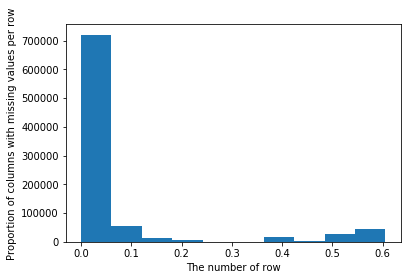

In [110]:
plt.hist(missing_values_rows)
plt.ylabel('Proportion of columns with missing values per row')
plt.xlabel('The number of row')
plt.show()

In [111]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_subset1 = azdias[missing_values_rows<0.3]
azdias_subset2 = azdias[missing_values_rows>=0.3]

In [112]:
azdias_subset1.shape, azdias_subset2.shape

((797872, 76), (93349, 76))

In [113]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
no_missing_columns = null_values[null_values==0].index.tolist()
no_missing_columns[:5]

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER']

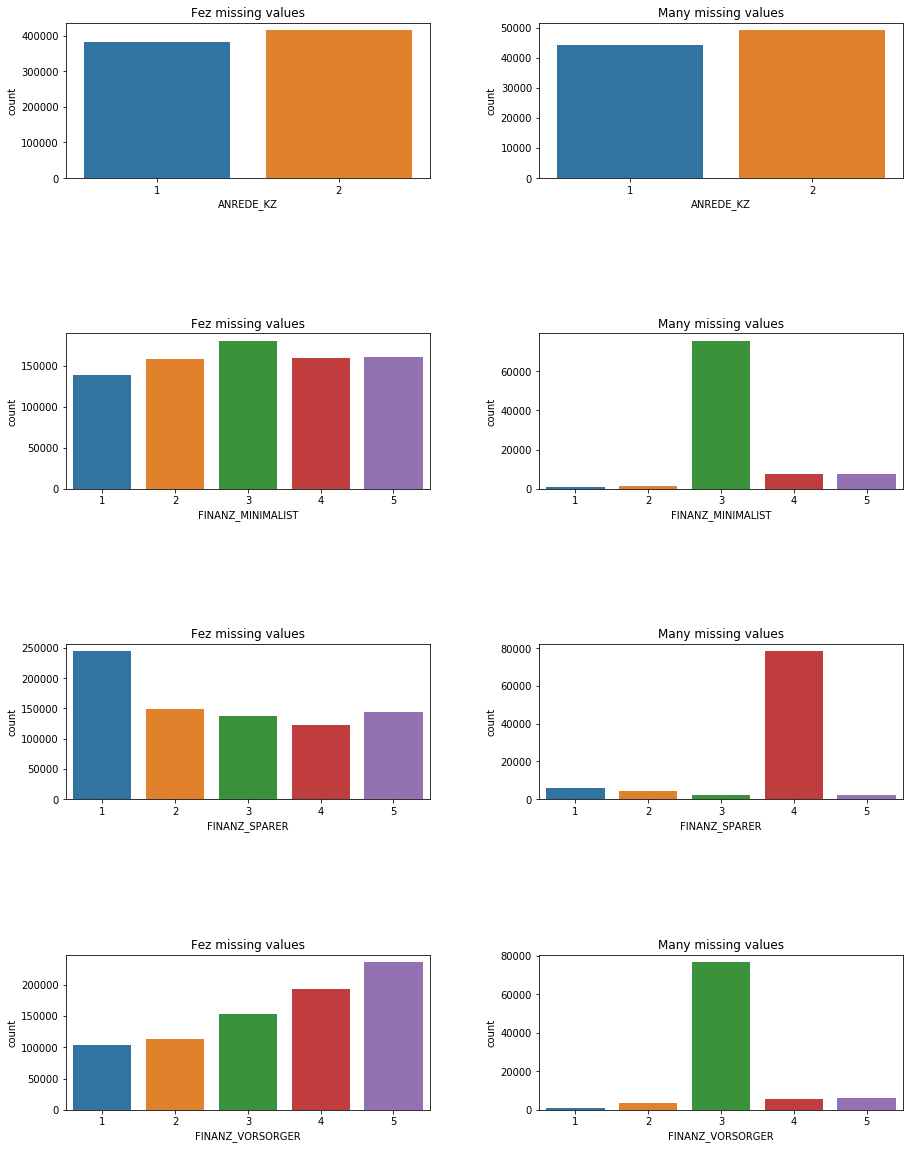

In [114]:
nb_to_compare = 4
figure, axs = plt.subplots(nrows=len(no_missing_columns[:nb_to_compare]), ncols=2, figsize = (15,20))
figure.subplots_adjust(hspace = 1, wspace=.3)
for i in range(nb_to_compare):
    sns.countplot(azdias_subset1[no_missing_columns[i]], ax=axs[i][0])
    axs[i][0].set_title('Fez missing values')
    sns.countplot(azdias_subset2[no_missing_columns[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

The histograms above shows that the rows with many missing values are not uniformly distributed values-wise. For this subset of a dataset, one can notice an important influence of outiers. We do not observe tendecy in the subset with few missing values per row. Therefore, we are going to use only the subset with few or none of missing values per row.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [115]:
# How many features are there of each data type?
column_names = azdias_subset1.columns.tolist()
subste_feat_info = feat_info[feat_info["attribute"].isin(column_names)]
subste_feat_info["type"].value_counts()


ordinal        46
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [116]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [117]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categ_vars = subste_feat_info[subste_feat_info["type"]=="categorical"]
feat_info.columns

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

In [118]:
binary_vars = []
multi_level = []
for col in categ_vars['attribute']:
    if azdias_subset1[col].nunique() == 2:
        binary_vars.append(col)
        print(azdias_subset1[col].value_counts())
    else:
        multi_level.append(col)
    

2    416073
1    381799
Name: ANREDE_KZ, dtype: int64
0    622677
1    175195
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791157
1.0      6715
Name: SOHO_KZ, dtype: int64
2.0    394202
1.0    367007
Name: VERS_TYP, dtype: int64
W    629356
O    168516
Name: OST_WEST_KZ, dtype: int64


In [119]:
'PRAEGENDE_JUGENDJAHRE' in multi_level

False

In [120]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_subset1["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
azdias_subset1["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
azdias_subset1["VERS_TYP"].replace({1.0:0,2.0:1},inplace=True)
#non numerical variables
azdias_subset1["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)
azdias_subset1["OST_WEST_KZ"].astype('int',inplace=True)



/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
12        0
13        0
15        0
16        0
18        0
19        0
20        0
21        0
22        0
23        0
25        0
26        0
27        0
28        0
29        0
31        0
32        0
33        0
34        0
36        0
         ..
891191    0
891192    0
891193    0
891194    0
891195    0
891196    0
891197    0
891198    0
891199    0
891200    0
891201    0
891202    0
891203    0
891204    0
891205    0
891206    0
891207    0
891208    0
891209    0
891210    0
891211    0
891212    0
891213    0
891214    0
891215    0
891216    0
891217    0
891218    0
891219    0
891220    0
Name: OST_WEST_KZ, Length: 797872, dtype: int64

In [121]:
azdias_subset1 = pd.get_dummies(azdias_subset1, columns = multi_level)

In [122]:
azdias_subset1['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [123]:
multi_level[:5]

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB']

In [124]:
# for col in  azdias_subset1.columns:
#     if azdias_subset1[col].nunique() == 2:
#         print(azdias_subset1[col].value_counts())


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

### Comments <br>
Five columns have been re-encoded to 0-1 convection. These columns are now suitable for ML algorithms.
Multicategorical columns have changed too. New dummy variables have been created and original multilevel columns have been dropped.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [125]:
azdias_subset1['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    182961
8.0     141596
10.0     85789
5.0      84681
3.0      53836
15.0     42537
11.0     35741
9.0      33565
6.0      25652
12.0     24445
1.0      20678
4.0      20450
2.0       7479
13.0      5762
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [126]:
# maping int numbers to decades 
# for example 1-->the 40s 
decade_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}

In [127]:
azdias_subset1["DECADE"] = azdias_subset1['PRAEGENDE_JUGENDJAHRE']
azdias_subset1["DECADE"].replace(decade_dict,inplace=True)

In [128]:
azdias_subset1["DECADE"].value_counts()

6.0    225498
4.0    175161
5.0    151737
3.0    114342
2.0     74286
1.0     28157
Name: DECADE, dtype: int64

In [129]:
# avantgarde 0 vs. mainstream 1
movement_dict={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}

In [130]:
azdias_subset1["MOVEMENT"] = azdias_subset1['PRAEGENDE_JUGENDJAHRE']
azdias_subset1["MOVEMENT"].replace(movement_dict,inplace=True)

In [131]:
azdias_subset1["MOVEMENT"].value_counts()

1.0    593986
0.0    175195
Name: MOVEMENT, dtype: int64

In [132]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_subset1['PRAEGENDE_JUGENDJAHRE'].head()


1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [133]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_subset1['CAMEO_INTL_2015'].value_counts()

51    133690
41     92333
24     91141
14     62878
43     56667
54     45389
25     39623
22     33145
23     26730
13     26330
45     26131
55     23954
52     20542
31     19014
34     18522
15     16973
44     14820
12     13245
35     10355
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [134]:
#Wealth and Life Stage dict
wealth_dict={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
life_dict={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }

#create two features
azdias_subset1["WEALTH"] = azdias_subset1["CAMEO_INTL_2015"]
azdias_subset1["LIFE_STAGE"] = azdias_subset1["CAMEO_INTL_2015"]
#replace with new variables
azdias_subset1["WEALTH"].replace(wealth_dict,inplace=True)
azdias_subset1["LIFE_STAGE"].replace(life_dict,inplace=True)

In [135]:
# dropping redundant columns
azdias_subset1.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
azdias_subset1.drop("CAMEO_INTL_2015",axis=1,inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

The feature extractions have been applied as "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" allowed to obtain additional information and variables.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [136]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
mixed_variables=feat_info[feat_info.type=="mixed"]
for mixed_feature in mixed_variables["attribute"]:
    if mixed_feature in azdias_subset1.columns:
        azdias_subset1.drop(mixed_feature,axis=1,inplace=True)


In [137]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_subset1.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
count,795072.000000,797872.000000,797872.00000,797872.000000,797872.000000,797872.000000,797872.000000,797872.000000,797872.000000,761209.000000,...,797872.000000,797872.000000,797872.000000,797872.000000,797872.000000,797872.000000,769181.000000,769181.000000,791771.00000,791771.000000
mean,2.795386,0.478522,3.05883,2.715986,3.432913,2.840899,2.658070,3.114452,0.219578,2.199074,...,0.022029,0.025746,0.034686,0.031317,0.035837,0.007994,4.331974,0.772232,3.26221,2.885569
std,1.018448,0.499539,1.37756,1.485101,1.376910,1.472761,1.399459,1.408003,0.413961,0.755159,...,0.146777,0.158377,0.182983,0.174173,0.185883,0.089050,1.457449,0.419393,1.46450,1.490037
min,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.00000,1.000000
25%,2.000000,0.000000,2.00000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,2.00000,1.000000
50%,3.000000,0.000000,3.00000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,4.00000,3.000000
75%,4.000000,1.000000,4.00000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.000000,5.00000,4.000000
max,4.000000,1.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,5.00000,5.000000


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [138]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    aux_df = df.copy()
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_or_unknown = feat_info.iloc[0]['missing_or_unknown']
    feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].str.extract(r"\[(.*)\]", expand=False).str.split(",")
    for indx in range(len(feat_info)): #
        column_name = feat_info.iloc[indx]['attribute']
        missing_or_unknown = to_int_list(feat_info.iloc[indx]['missing_or_unknown'])
        for el in missing_or_unknown:
            aux_df[column_name] = aux_df[column_name].replace(el,np.nan)
    # Assess Missing Data in Each Column
    null_values = aux_df.isnull().mean()
    percentile90th = null_values.quantile(0.9)
    outlier_columns_toremove = list(null_values[null_values>percentile90th].index)
    aux_df = aux_df.drop(columns=outlier_columns_toremove, axis=1)
    #Missing Data in Each Row
    missing_values_rows = aux_df.isnull().mean(axis=1)
    aux_df = aux_df[missing_values_rows<0.3]
    #  Re-Encode Categorical Features
    column_names = aux_df.columns.tolist()
    subste_feat_info = feat_info[feat_info["attribute"].isin(column_names)]
    binary_vars = []
    multi_level = []
    for col in categ_vars['attribute']:
        if aux_df[col].nunique() == 2:
            binary_vars.append(col)
            print(aux_df[col].value_counts())
        else:
            multi_level.append(col)
    # Re-encode categorical variable(s) to be kept in the analysis.
    aux_df["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
    aux_df["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
    aux_df["VERS_TYP"].replace({1.0:0,2.0:1},inplace=True)
    #non numerical variables
    aux_df["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)
    aux_df["OST_WEST_KZ"].astype('int',inplace=True)
    aux_df = pd.get_dummies(aux_df, columns = multi_level)
    # remove selected columns and rows, ...
    
    
    # select, re-encode, and engineer column values.
    decade_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    aux_df["DECADE"] = aux_df['PRAEGENDE_JUGENDJAHRE']
    aux_df["DECADE"].replace(decade_dict,inplace=True)
    movement_dict={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    aux_df["MOVEMENT"] = aux_df['PRAEGENDE_JUGENDJAHRE']
    aux_df["MOVEMENT"].replace(movement_dict,inplace=True)
    
    wealth_dict={'11':1,'12':1,'13':1,'14':1,'15':1,
            '21':2,'22':2,'23':2,'24':2,'25':2,
            '31':3,'32':3,'33':3,'34':3,'35':3,
            '41':4,'42':4,'43':4,'44':4,'45':4,
            '51':5,'52':5,'53':5,'54':5,'55':5
            }
    life_dict={'11':1,'12':2,'13':3,'14':4,'15':5,
            '21':1,'22':2,'23':3,'24':4,'25':5,
            '31':1,'32':2,'33':4,'34':4,'35':5,
            '41':1,'42':2,'43':3,'44':4,'45':5,
            '51':1,'52':2,'53':3,'54':4,'55':5
            }

    #create two features
    aux_df["WEALTH"] = aux_df["CAMEO_INTL_2015"]
    aux_df["LIFE_STAGE"] = aux_df["CAMEO_INTL_2015"]
    #replace with new variables
    aux_df["WEALTH"].replace(wealth_dict,inplace=True)
    aux_df["LIFE_STAGE"].replace(life_dict,inplace=True)

    aux_df.drop("PRAEGENDE_JUGENDJAHRE",axis=1,inplace=True)
    aux_df.drop("CAMEO_INTL_2015",axis=1,inplace=True)
    
    mixed_variables=feat_info[feat_info.type=="mixed"]
    for mixed_feature in mixed_variables["attribute"]:
        if mixed_feature in aux_df.columns:
            aux_df.drop(mixed_feature,axis=1,inplace=True)
    # Return the cleaned dataframe.
    
    return aux_df
    
    

In [139]:
feat_info = pd.read_table("AZDIAS_Feature_Summary.csv",sep=';')
azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv" ,delimiter=";")
test_df = clean_data(azdias_test,feat_info)
test_df.head()

2    416073
1    381799
Name: ANREDE_KZ, dtype: int64
0    622677
1    175195
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791157
1.0      6715
Name: SOHO_KZ, dtype: int64
2.0    394202
1.0    367007
Name: VERS_TYP, dtype: int64
W    629356
O    168516
Name: OST_WEST_KZ, dtype: int64


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,0,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,6.0,1.0,5.0,1.0
2,3.0,0,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,6.0,0.0,2.0,4.0
3,4.0,0,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,4.0,1.0,4.0,3.0
5,1.0,0,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,2.0,1.0,5.0,4.0


In [140]:
azdias_subset1.shape, test_df.shape

((797872, 189), (797872, 189))

In [141]:
test_df.equals(azdias_subset1)

True

### As we can  our cleaning function allowed to obtain the same results as single commands.

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [142]:
from sklearn.preprocessing import StandardScaler, Imputer

In [143]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.pipeline import Pipeline
si = Imputer(strategy='most_frequent')
ss = StandardScaler()
steps = [('si', si), ('ss', ss)]
pipe = Pipeline(steps)
X_t = pipe.fit_transform(azdias_subset1)


In [144]:
# Apply feature scaling to the general population demographics data.

X_t[:2]

array([[ -1.76654903e+00,  -9.57927467e-01,  -1.49454921e+00,
          1.53795353e+00,  -1.04067331e+00,   1.46602367e+00,
          9.58892431e-01,   1.33916598e+00,  -5.30431664e-01,
          1.01017355e+00,  -1.68527219e+00,   4.43064428e-01,
         -5.92965818e-02,   2.91478409e-03,  -4.63797316e-01,
         -1.68459925e+00,  -1.10995008e+00,  -1.43540419e+00,
         -5.78218517e-01,   1.27418170e+00,  -3.12107706e-01,
          1.33923150e+00,  -1.57553887e-01,   1.51854685e+00,
          1.28891999e+00,   1.08544627e+01,   9.22925330e-01,
          2.34381749e-01,  -6.03841031e-02,   1.02652980e+00,
          5.67139302e-01,   1.73008041e-01,  -1.25132886e-01,
         -1.30446675e+00,  -3.83215734e-01,  -5.17454755e-01,
         -1.00908465e+00,  -9.65918401e-01,  -5.94972459e-01,
          2.73029894e+00,  -1.65910213e+00,   8.45259018e-01,
         -5.47212979e-01,   1.70115844e+00,  -7.99693681e-01,
         -1.28012430e+00,   1.67067065e-01,   9.43160407e-01,
        

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.) <br>
We used the pipeline to perform feauture transfortion. It is a short pipline consisting of:
filling the data with most common values and standarizing the values of each column.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [145]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(X_t)


In [146]:
# Investigate the variance accounted for by each principal component.

pca_components = list(range(len(pca.explained_variance_ratio_)))
pca_total = np.cumsum(pca.explained_variance_ratio_)


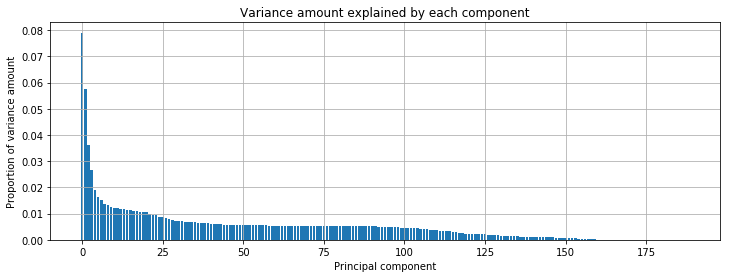

In [147]:
plt.rcParams["figure.figsize"] = (12,4)
plt.bar(pca_components, pca.explained_variance_ratio_)
plt.title("Variance amount explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Proportion of variance amount")
plt.grid()
plt.show()

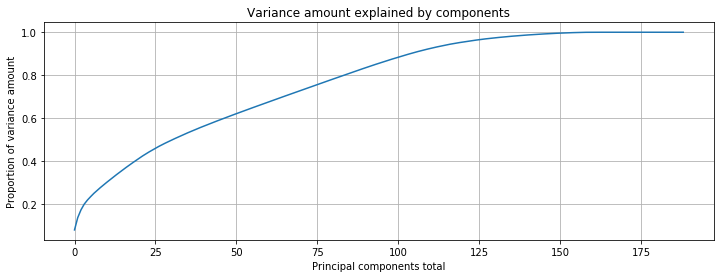

In [148]:
plt.plot(pca_components,pca_total)
plt.title("Variance amount explained by components")
plt.xlabel("Principal components total")
plt.ylabel("Proportion of variance amount")
plt.grid()
plt.show()


In [149]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_model = PCA(n_components=80)
X_pca = pca_model.fit_transform(X_t)
np.sum(pca.explained_variance_ratio_)

1.0

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?) <br>
I have chosen to retain 80 components for my reduced dataset as it allows to explain around 80% of variance of the dataset.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [150]:
pca_model

PCA(copy=True, iterated_power='auto', n_components=80, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [151]:

def map_weights(pca_model, features_name=None, component_number=0):
    df = pd.DataFrame(pca_model.components_, columns=features_name)
    weights = df.iloc[component_number].sort_values(ascending=False)
    return weights    


In [152]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
columns_names =  list(azdias_subset1.columns)
pca_weight_1 = map_weights(pca_model, columns_names,component_number=0)
print (pca_weight_1)

LP_STATUS_GROB_1.0      0.197242
HH_EINKOMMEN_SCORE      0.185263
WEALTH                  0.183890
PLZ8_ANTG3              0.181503
PLZ8_ANTG4              0.175164
ORTSGR_KLS9             0.154855
EWDICHTE                0.153443
FINANZ_HAUSBAUER        0.147514
KBA05_ANTG4             0.129282
PLZ8_ANTG2              0.125102
LP_STATUS_FEIN_1.0      0.125089
FINANZ_SPARER           0.124451
LP_STATUS_FEIN_2.0      0.120595
FINANZTYP_1             0.119726
KBA05_ANTG3             0.117490
ANZ_HAUSHALTE_AKTIV     0.116125
CAMEO_DEUG_2015_9       0.114158
ARBEIT                  0.112858
RELAT_AB                0.107324
MOVEMENT                0.104308
CAMEO_DEUG_2015_8       0.092289
SEMIO_PFLICHT           0.091488
DECADE                  0.087278
SEMIO_REL               0.086881
LP_FAMILIE_FEIN_1.0     0.085205
LP_FAMILIE_GROB_1.0     0.085205
ZABEOTYP_5              0.079783
SEMIO_RAT               0.076830
GEBAEUDETYP_3.0         0.068369
SEMIO_TRADV             0.067522
          

In [153]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_2 = map_weights(pca_model, columns_names,component_number=1)
print (pca_weight_2)


ALTERSKATEGORIE_GROB     0.231732
FINANZ_VORSORGER         0.216364
ZABEOTYP_3               0.201179
SEMIO_ERL                0.183346
SEMIO_LUST               0.161217
RETOURTYP_BK_S           0.155543
CJT_GESAMTTYP_2.0        0.106323
LP_STATUS_FEIN_1.0       0.105467
FINANZTYP_5              0.098170
FINANZ_HAUSBAUER         0.093825
FINANZTYP_2              0.087822
FINANZ_MINIMALIST        0.078448
SEMIO_KRIT               0.077358
PLZ8_ANTG3               0.075339
SHOPPER_TYP_3.0          0.075171
EWDICHTE                 0.073946
PLZ8_ANTG4               0.073678
ORTSGR_KLS9              0.073003
CJT_GESAMTTYP_1.0        0.069855
FINANZTYP_6              0.069113
WEALTH                   0.068936
SEMIO_KAEM               0.065534
NATIONALITAET_KZ_1.0     0.065079
KBA05_ANTG4              0.059761
GFK_URLAUBERTYP_4.0      0.059492
LP_FAMILIE_GROB_1.0      0.057901
LP_FAMILIE_FEIN_1.0      0.057901
ARBEIT                   0.056850
WOHNDAUER_2008           0.053963
ANZ_HAUSHALTE_

In [154]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_3 = map_weights(pca_model, columns_names,component_number=2)
print (pca_weight_3)


ANREDE_KZ                0.345793
SEMIO_VERT               0.320226
SEMIO_FAM                0.258301
SEMIO_SOZ                0.256878
SEMIO_KULT               0.250272
FINANZTYP_5              0.135622
FINANZ_MINIMALIST        0.131245
SHOPPER_TYP_0.0          0.121837
ZABEOTYP_1               0.113452
SEMIO_REL                0.108297
SEMIO_MAT                0.085883
RETOURTYP_BK_S           0.078401
GREEN_AVANTGARDE         0.070697
ORTSGR_KLS9              0.066573
EWDICHTE                 0.065863
SHOPPER_TYP_1.0          0.053524
PLZ8_ANTG4               0.052795
PLZ8_ANTG3               0.052429
FINANZ_VORSORGER         0.051320
LP_STATUS_FEIN_10.0      0.050210
LP_STATUS_GROB_5.0       0.050210
ZABEOTYP_6               0.050093
LP_STATUS_FEIN_1.0       0.049006
LP_STATUS_FEIN_3.0       0.043777
RELAT_AB                 0.038397
ARBEIT                   0.037757
PLZ8_ANTG2               0.037402
LP_STATUS_GROB_3.0       0.032496
GEBAEUDETYP_3.0          0.030501
NATIONALITAET_

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?) <ul>
<b>the first principal component: </b> The most important features for this component are:
<ol><li>positive: 
    <ul>
<li> LP_STATUS_GROB_1.0      0.197242-Social status, rough scale-1: low-income earners (maps to 1-2 in fine scale)</li> 
<li> HH_EINKOMMEN_SCORE      0.185263: Estimated household net income</li>
<li> WEALTH                  0.183890</li>
    </ul>     
        </li>
<li>negative: 
    <ul>
        <li> PLZ8_ANTG1             -0.182680: Number of 1-2 family houses in the PLZ8 region</li> 
        <li> MOBI_REGIO             -0.187999: Movement patterns</li>
        <li> FINANZ_MINIMALIST      -0.197145: Financial typology, for each dimension:</li>
    </ul> 
    </li>
</ol>
</ul>


<br>
<b>the second principal component: </b> The most important features for this component are:
<ol><li>positive: 
    <ul>
<li> ALTERSKATEGORIE_GROB     0.231732: Estimated age based on given name analysis</li> 
<li> FINANZ_VORSORGER         0.216364: Financial typology</li>
<li>ZABEOTYP_3               0.201179: Energy consumption typology</li>
    </ul>     
        </li>
<li>negative: 
    <ul>
        <li>SEMIO_REL               -0.216251: Personality typology</li> 
        <li>FINANZ_SPARER           -0.223656: Financial typology</li>
        <li>DECADE                  -0.227921</li>
    </ul> 
    </li>
</ol>


<br>
<b>the third principal component: </b> The most important features for this component are:
<ol><li>positive: 
    <ul>
        <li>ANREDE_KZ                0.345792: Gender</li> 
        <li>SEMIO_VERT               0.320225: Personality typology</li>
        <li>SEMIO_FAM                0.258301: Personality typology</li>
    </ul>     
        </li>
<li>negative: 
    <ul>
        <li>SEMIO_KRIT              -0.267435: Personality typology</li> 
        <li>SEMIO_DOM               -0.284659: Personality typology</li>
        <li>SEMIO_KAEM              -0.31399: Personality typology</li>
    </ul> 
    </li>
</ol>

We see that this dataset is strongly impacted by the financial and personality data. The impact of time (decades) is quite visible in the amount of variability of the dataset. This kind of analyses allows to draw conlusions and add interpretations to the pca components of the reduced dataset.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [155]:
# Over a number of different cluster counts...
from sklearn.cluster import KMeans
avg_distance = []
    # run k-means clustering on the data and...
for nb_clusters in range(2,25,2):
    kmeans = KMeans(n_clusters=nb_clusters).fit(X_pca)
    score = np.abs(kmeans.score(X_pca))
    # compute the average within-cluster distances.
    print(f"For n_clusters={nb_clusters}, the average within-cluster distance is {score/X_pca.shape[0]}")
    avg_distance.append(score/X_pca.shape[0])

    
    

For n_clusters=2, the average within-cluster distance is 134.7727571402563
For n_clusters=4, the average within-cluster distance is 125.56993822444794
For n_clusters=6, the average within-cluster distance is 120.74170280136245
For n_clusters=8, the average within-cluster distance is 117.33747894057723
For n_clusters=10, the average within-cluster distance is 114.85148344579858
For n_clusters=12, the average within-cluster distance is 112.82549540094746
For n_clusters=14, the average within-cluster distance is 111.02076917705989
For n_clusters=16, the average within-cluster distance is 110.24898019859556
For n_clusters=18, the average within-cluster distance is 109.09682110747005
For n_clusters=20, the average within-cluster distance is 107.41374719711234
For n_clusters=22, the average within-cluster distance is 105.64007207564208
For n_clusters=24, the average within-cluster distance is 104.83115609942905


In [156]:
avg_distance

[134.77275714025629,
 125.56993822444794,
 120.74170280136245,
 117.33747894057723,
 114.85148344579858,
 112.82549540094746,
 111.02076917705989,
 110.24898019859556,
 109.09682110747005,
 107.41374719711234,
 105.64007207564208,
 104.83115609942905]

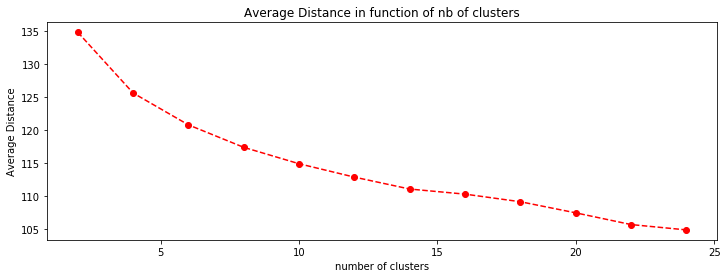

In [160]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
clusters_list = list(range(2,25,2))
plt.plot(clusters_list, avg_distance, linestyle='--', marker='o', color='r');
plt.xlabel('number of clusters');
plt.ylabel('Average Distance');
plt.title('Average Distance in function of nb of clusters');


In [161]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters=12).fit(X_pca)
k_means_predictions = model.predict(X_pca)

### Discussion 3.1: Apply Clustering to General Population

Using the elbow method, the elbow point is not clearly pronounced, the change in within-cluster distance started decreasing around 12 clusters. Thus, the 12 clusters have been chosen for the final kmean model.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [162]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')

In [163]:
customers.shape

(191652, 85)

In [164]:
feat_info = pd.read_table("AZDIAS_Feature_Summary.csv",sep=';')


In [165]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean= clean_data(customers, feat_info)
customers_clean.head(3)

1    94834
2    46861
Name: ANREDE_KZ, dtype: int64
0    71333
1    70362
Name: GREEN_AVANTGARDE, dtype: int64
0.0    140301
1.0      1394
Name: SOHO_KZ, dtype: int64
1.0    70619
2.0    68741
Name: VERS_TYP, dtype: int64
W    130353
O     11342
Name: OST_WEST_KZ, dtype: int64


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,0,2.0,0.0,1.0,3.0
2,4.0,0,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,0,2.0,0.0,3.0,4.0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0,1.0,1.0,2.0,4.0


In [166]:
customers_clean.shape, test_df.shape

((141695, 188), (797872, 189))

In [167]:
# One column is different 

list(set(test_df)-set(customers_clean.columns))

['GEBAEUDETYP_5.0']

In [168]:
# we have to add one column to the customers_clean dataframe
customers_clean['GEBAEUDETYP_5.0'] = 0

In [169]:
scaler = StandardScaler() 
imputer = Imputer(strategy='most_frequent')
aux = imputer.fit_transform(customers_clean)
X_customers_t = scaler.fit_transform(aux)

In [170]:
X_customers_t.shape

(141695, 189)

In [171]:
pca_model = PCA(n_components=80)
X_pca_clients = pca_model.fit_transform(X_customers_t)

In [172]:
predicitons_customers= model.predict(X_pca_clients)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

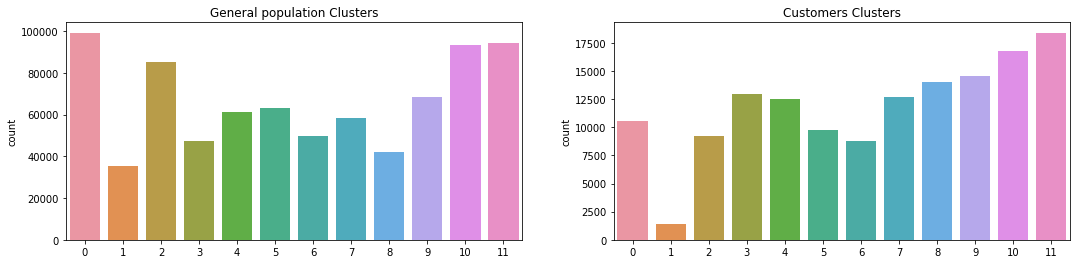

In [173]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(18)
ax1.set_title('General population Clusters')
sns.countplot(k_means_predictions,ax=ax1)

ax2.set_title('Customers Clusters')
sns.countplot(predicitons_customers,ax=ax2)
plt.show()



In [174]:
positive_correlation = ["LP_STATUS_GROB_1.0",
                       "HH_EINKOMMEN_SCORE",
                       "WEALTH",
                       "ALTERSKATEGORIE_GROB",
                       "FINANZ_VORSORGER",
                       "ZABEOTYP_3",
                       "ANREDE_KZ",
                        "SEMIO_VERT",
                        "SEMIO_FAM"
                       ]


In [175]:
negative_correlation = ["PLZ8_ANTG1",
                       "MOBI_REGIO",
                        "FINANZ_MINIMALIST",
                        "SEMIO_REL",
                       "FINANZ_SPARER",
                        "DECADE",
                        "SEMIO_KRIT",
                        "SEMIO_DOM",
                        "SEMIO_KAEM"
                       ]

In [176]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_6 = scaler.inverse_transform(pca_model.inverse_transform(model.cluster_centers_[6]))

In [177]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_2 = scaler.inverse_transform(pca_model.inverse_transform(model.cluster_centers_[2]))


In [178]:
overrepresented_c = pd.Series(data = centroid_6, index = customers_clean.columns)
overrepresented_c

ALTERSKATEGORIE_GROB     4.018475
ANREDE_KZ                0.980371
FINANZ_MINIMALIST        5.128963
FINANZ_SPARER            0.501629
FINANZ_VORSORGER         5.444028
FINANZ_ANLEGER           0.670162
FINANZ_UNAUFFAELLIGER    1.240666
FINANZ_HAUSBAUER         2.550535
GREEN_AVANTGARDE         0.498996
HEALTH_TYP               1.619256
RETOURTYP_BK_S           4.446412
SEMIO_SOZ                4.906607
SEMIO_FAM                4.216944
SEMIO_REL                3.071343
SEMIO_MAT                3.861963
SEMIO_VERT               6.432920
SEMIO_LUST               6.581737
SEMIO_ERL                4.519950
SEMIO_KULT               4.383831
SEMIO_RAT                2.097720
SEMIO_KRIT               2.936255
SEMIO_DOM                2.828147
SEMIO_KAEM               2.227693
SEMIO_PFLICHT            2.148870
SEMIO_TRADV              2.468958
SOHO_KZ                  0.007550
VERS_TYP                 0.360274
ANZ_PERSONEN             2.402363
ANZ_TITEL                0.125620
HH_EINKOMMEN_S

In [179]:
underrepresented_c = pd.Series(data = centroid_2, index = customers_clean.columns)
underrepresented_c

ALTERSKATEGORIE_GROB     2.824971
ANREDE_KZ                0.173893
FINANZ_MINIMALIST        3.151516
FINANZ_SPARER            2.432296
FINANZ_VORSORGER         3.606585
FINANZ_ANLEGER           2.954430
FINANZ_UNAUFFAELLIGER    2.409128
FINANZ_HAUSBAUER         3.047322
GREEN_AVANTGARDE         0.046326
HEALTH_TYP               2.399290
RETOURTYP_BK_S           3.242594
SEMIO_SOZ                3.344496
SEMIO_FAM                3.090180
SEMIO_REL                3.173444
SEMIO_MAT                3.087326
SEMIO_VERT               3.236975
SEMIO_LUST               4.327991
SEMIO_ERL                5.841004
SEMIO_KULT               2.972273
SEMIO_RAT                4.209469
SEMIO_KRIT               5.605584
SEMIO_DOM                5.579950
SEMIO_KAEM               5.636746
SEMIO_PFLICHT            4.070310
SEMIO_TRADV              3.216409
SOHO_KZ                  0.020183
VERS_TYP                 0.633599
ANZ_PERSONEN             2.213294
ANZ_TITEL                0.007902
HH_EINKOMMEN_S

In [181]:
centroids=pd.DataFrame({"feature":customers_clean.columns,"centroid_6":centroid_6,"centroid_2":centroid_2})
centroids[centroids["feature"].isin(positive_correlation)]


,feature,centroid_6,centroid_2
0,ALTERSKATEGORIE_GROB,4.018475,2.824971
1,ANREDE_KZ,0.980371,0.173893
4,FINANZ_VORSORGER,5.444028,3.606585
12,SEMIO_FAM,4.216944,3.090180
15,SEMIO_VERT,6.432920,3.236975
29,HH_EINKOMMEN_SCORE,2.286795,4.507661
107,LP_STATUS_GROB_1.0,-0.003667,0.324184
121,ZABEOTYP_3,0.481613,0.508643
186,WEALTH,1.207226,3.032173


In [182]:
centroids[centroids["feature"].isin(negative_correlation)]

,feature,centroid_6,centroid_2
2,FINANZ_MINIMALIST,5.128963,3.151516
3,FINANZ_SPARER,0.501629,2.432296
13,SEMIO_REL,3.071343,3.173444
20,SEMIO_KRIT,2.936255,5.605584
21,SEMIO_DOM,2.828147,5.579950
22,SEMIO_KAEM,2.227693,5.636746
45,MOBI_REGIO,4.338067,3.132912
48,PLZ8_ANTG1,3.271707,2.347547
184,DECADE,1.579772,4.285668


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

The Cluster 6 is overrepresented in the customer data compared to the general population, the following conslusions can be drawn about the customers:

The customers of the mail-order company are unlikely to be low financial interest people and money savers as well as old rich people.

Their clients are likely to be middle class earning middle class money salary. Their personality is dreamful, family oriented. 


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.